# Évaluation Sommative 1 — Pipeline complet de préparation de données 

## Objectif
Ce notebook construit un pipeline complet de préparation de données pour le dataset **Credit Card Fraud Detection** (Kaggle) et compare les performances d’un modèle **avant** et **après** l’application de méthodes de rééchantillonnage.

Le notebook couvre :
1. Analyse initiale et visualisations de base  
2. Diagnostic (déséquilibre, outliers, asymétrie)  
3. Préparation des données (feature engineering + transformations) sans classes personnalisées  
4. Modèle de base (sans rééchantillonnage)  
5. Comparaison : baseline vs class_weight vs UnderSampling vs SMOTE  
6. Ajustement du seuil de décision (threshold tuning)  
7. Validation et export des jeux de données finaux  

## Remarque importante
Toutes les transformations sont apprises sur le jeu d’entraînement puis appliquées au jeu de test pour éviter la fuite de données.


In [7]:
#  Imports
#from google.colab import drive
#drive.mount('/content/drive')
import sys
print(sys.executable)

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay,
    precision_score, recall_score, f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


/home/alouiyaz/projet_ia/.venv/bin/python


## 1) Chargement des données

Place le fichier `creditcard.csv` dans le même dossier que ce notebook, puis exécute la cellule suivante.


In [8]:
# Chargement des données sur le pc décommenter au cas vous avez les données sur votre pc et vos avez pas besoin de gpu de collab
# df = pd.read_csv("creditcard.csv")


In [9]:
#import kagglehub
#from kagglehub import KaggleDatasetAdapter

# 1. Spécifier le fichier exact dans le dataset
file_path = "creditcard.csv"

# 2. Charger en tant que DataFrame Pandas
#df = kagglehub.load_dataset(
 # KaggleDatasetAdapter.PANDAS, "mlg-ulb/creditcardfraud",file_path)
df = pd.read_csv("creditcard.csv")

print("Chargement réussi via KaggleHub !")
print("Dimensions:", df.shape)
df.head()


Chargement réussi via KaggleHub !
Dimensions: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Analyse initiale

- La cible est `Class` (0 = transaction normale, 1 = fraude).  
- Le dataset est fortement déséquilibré : la fraude est rare.


Class
0    284315
1       492
Name: count, dtype: int64
Fraud rate (%): 0.1727


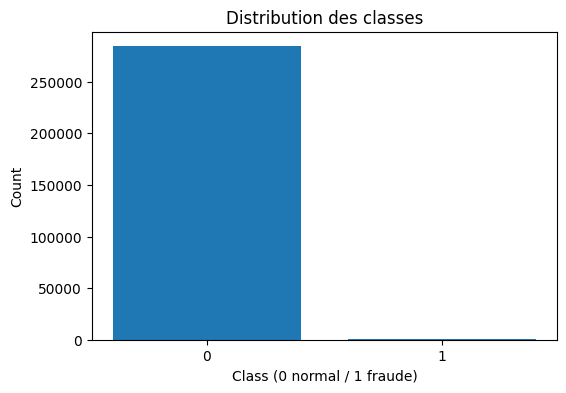

In [10]:
counts = df["Class"].value_counts()
fraud_rate = df["Class"].mean() * 100

print(counts)
print(f"Fraud rate (%): {fraud_rate:.4f}")

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution des classes")
plt.xlabel("Class (0 normal / 1 fraude)")
plt.ylabel("Count")
plt.show()


## 3) Visualisations utiles

### 3.1 Amount : Normal vs Fraude (axe Y en log)

Ce graphique est utile pour constater que de nombreuses fraudes peuvent se produire sur des montants faibles.


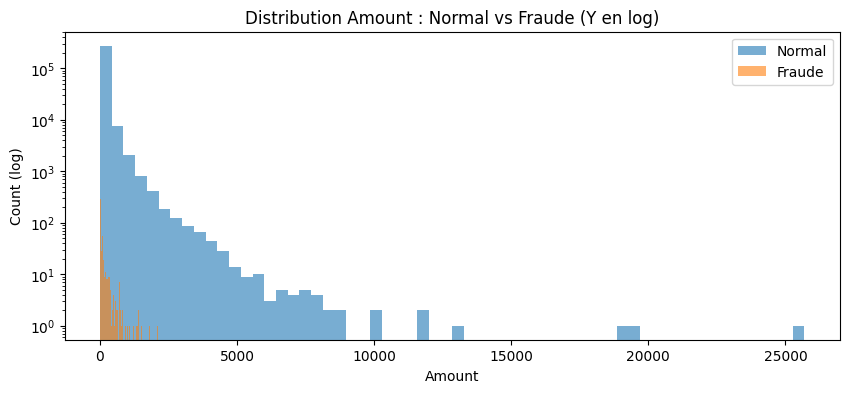

In [11]:
plt.figure(figsize=(10,4))
plt.hist(df[df["Class"]==0]["Amount"], bins=60, alpha=0.6, label="Normal")
plt.hist(df[df["Class"]==1]["Amount"], bins=60, alpha=0.6, label="Fraude")
plt.yscale("log")
plt.title("Distribution Amount : Normal vs Fraude (Y en log)")
plt.xlabel("Amount")
plt.ylabel("Count (log)")
plt.legend()
plt.show()


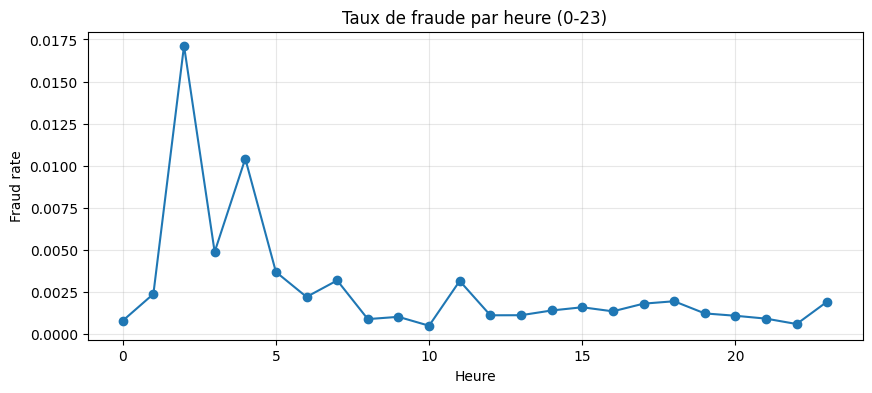

In [12]:
df_hour = df.copy()
df_hour["Hour"] = (df_hour["Time"] // 3600) % 24

fraud_rate_by_hour = df_hour.groupby("Hour")["Class"].mean()

plt.figure(figsize=(10,4))
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker="o")
plt.title("Taux de fraude par heure (0-23)")
plt.xlabel("Heure")
plt.ylabel("Fraud rate")
plt.grid(True, alpha=0.3)
plt.show()


### 3.2 Taux de fraude par tranche de montant (déciles)

Un histogramme montre des comptages, pas directement un risque.  
Cette visualisation calcule le taux de fraude par déciles de `Amount`.


/tmp/ipykernel_26857/1996713903.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = df_tmp.groupby("amount_bin")["Class"].mean()


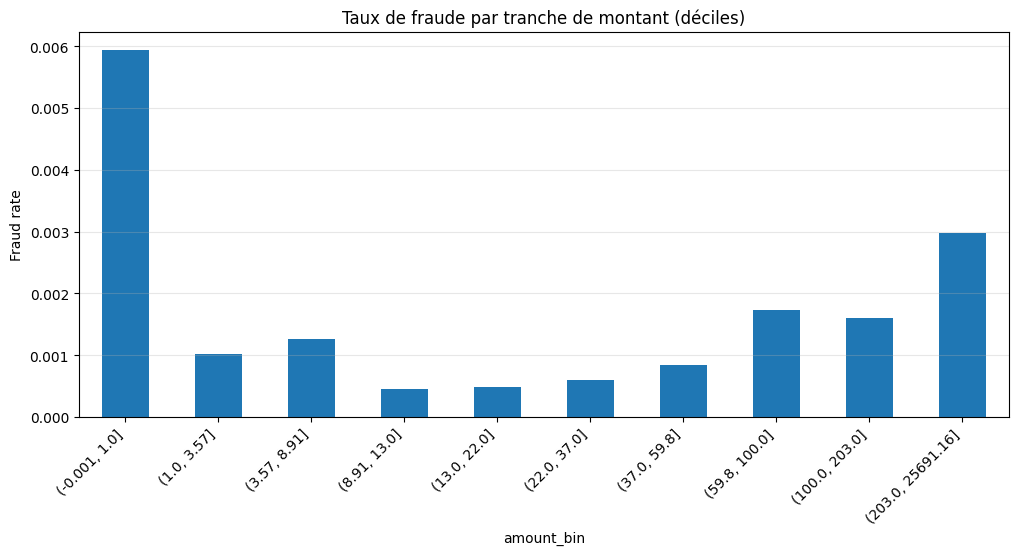

In [13]:
df_tmp = df.copy()
df_tmp["amount_bin"] = pd.qcut(df_tmp["Amount"], q=10, duplicates="drop")
fraud_rate_by_bin = df_tmp.groupby("amount_bin")["Class"].mean()

plt.figure(figsize=(12,5))
fraud_rate_by_bin.plot(kind="bar")
plt.title("Taux de fraude par tranche de montant (déciles)")
plt.ylabel("Fraud rate")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


## 4) Diagnostic : outliers (IQR), asymétrie (skewness) et corrélations

Ces diagnostics aident à justifier :
- l’utilisation d’un scaler robuste (RobustScaler) en présence d’outliers,  
- l’utilisation de transformations (log, Yeo-Johnson) en présence d’asymétrie,  
- le choix de certaines variables à transformer.


In [14]:
# 4.1 Outliers (IQR)
def detect_outliers_iqr(data: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    out = {}
    for col in features:
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        out[col] = ((data[col] < low) | (data[col] > high)).sum()

    return (pd.DataFrame(out.items(), columns=["Variable", "Nb_Outliers"])
              .sort_values("Nb_Outliers", ascending=False)
              .reset_index(drop=True))

features_to_check = ["Amount"] + [f"V{i}" for i in range(1, 29)]
df_outliers = detect_outliers_iqr(df, features_to_check)
df_outliers.head(12)


,Variable,Nb_Outliers
0,V27,39163
1,Amount,31904
2,V28,30342
3,V20,27770
4,V8,24134
5,V6,22965
6,V23,18541
7,V12,15348
8,V21,14497
9,V14,14149


In [15]:
# 4.2 Skewness
skew_vals = df[features_to_check].skew().sort_values(ascending=False)
skew_vals.head(12)


Amount    16.977724
V28       11.192091
V21        3.592991
V7         2.553907
V6         1.826581
V10        1.187141
V4         0.676292
V26        0.576693
V9         0.554680
V11        0.356506
V19        0.109192
V13        0.065233
dtype: float64

In [16]:
# 4.3 Corrélations avec la cible (aperçu)
corr = df.corr(numeric_only=True)["Class"].sort_values(key=lambda s: np.abs(s), ascending=False)
corr.head(12)


Class    1.000000
V17     -0.326481
V14     -0.302544
V12     -0.260593
V10     -0.216883
V16     -0.196539
V3      -0.192961
V7      -0.187257
V11      0.154876
V4       0.133447
V18     -0.111485
V1      -0.101347
Name: Class, dtype: float64

## 5) Split Train/Test 

Cette étape doit être faite avant le feature engineering et les transformations pour éviter la fuite de données.


In [17]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


Train class counts: [227451    394]
Test  class counts: [56864    98]


## 6) Feature engineering (sans classes)

Deux variables sont ajoutées :
- `Hour` : heure extraite depuis `Time` (en secondes).  
- `is_small_amount` : indicateur de petit montant, basé sur le quantile 25% du train.  

Le seuil de petit montant est appris sur le train uniquement.


In [18]:
small_threshold = X_train["Amount"].quantile(0.25)
print("Small amount threshold (Q25 train):", small_threshold)

def add_features(df_in: pd.DataFrame, small_thr: float) -> pd.DataFrame:
    df_ = df_in.copy()
    df_["Hour"] = (df_["Time"] // 3600) % 24
    df_["is_small_amount"] = (df_["Amount"] < small_thr).astype(int)
    return df_

X_train_fe = add_features(X_train, small_threshold)
X_test_fe  = add_features(X_test,  small_threshold)

tmp_small = pd.DataFrame({"is_small_amount": X_train_fe["is_small_amount"], "Class": y_train.values})
print("Taux de fraude selon is_small_amount (train):")
print(tmp_small.groupby("is_small_amount")["Class"].mean())


Small amount threshold (Q25 train): 5.64
Taux de fraude selon is_small_amount (train):
is_small_amount
0    0.001264
1    0.003125
Name: Class, dtype: float64


## 7) Transformations (sans classes)

Transformations appliquées :
1. `log1p(Amount)` puis `RobustScaler` (réduit l’asymétrie et l’impact des outliers)  
2. `RobustScaler` sur `Time`  
3. `Yeo-Johnson` sur une liste de variables `V` sélectionnées  

La liste `V_TO_TRANSFORM` est définie à partir des diagnostics (skewness élevé et/ou outliers massifs).


In [19]:
V_TO_TRANSFORM = ["V28","V21","V7","V6","V10","V27","V20","V8","V23","V12"]
V_TO_TRANSFORM


['V28', 'V21', 'V7', 'V6', 'V10', 'V27', 'V20', 'V8', 'V23', 'V12']

In [20]:
# Fit des transformations sur train uniquement

# 7.1 log1p(Amount)
X_train_fe = X_train_fe.copy()
X_test_fe = X_test_fe.copy()

X_train_fe["Amount_log"] = np.log1p(X_train_fe["Amount"])
X_test_fe["Amount_log"]  = np.log1p(X_test_fe["Amount"])

# 7.2 RobustScaler sur Amount_log et Time
sc_amount = RobustScaler()
sc_time = RobustScaler()

sc_amount.fit(X_train_fe[["Amount_log"]])
sc_time.fit(X_train_fe[["Time"]])

X_train_fe["scaled_amount"] = sc_amount.transform(X_train_fe[["Amount_log"]]).ravel()
X_test_fe["scaled_amount"]  = sc_amount.transform(X_test_fe[["Amount_log"]]).ravel()

X_train_fe["scaled_time"] = sc_time.transform(X_train_fe[["Time"]]).ravel()
X_test_fe["scaled_time"]  = sc_time.transform(X_test_fe[["Time"]]).ravel()

# 7.3 Yeo-Johnson sur variables V sélectionnées
pt = PowerTransformer(method="yeo-johnson")
pt.fit(X_train_fe[V_TO_TRANSFORM])

X_train_fe[V_TO_TRANSFORM] = pt.transform(X_train_fe[V_TO_TRANSFORM])
X_test_fe[V_TO_TRANSFORM]  = pt.transform(X_test_fe[V_TO_TRANSFORM])

# 7.4 Suppression des colonnes brutes redondantes
DROP_COLS = ["Time", "Amount", "Amount_log"]
X_train_ready = X_train_fe.drop(columns=DROP_COLS)
X_test_ready = X_test_fe.drop(columns=DROP_COLS)

print("Train ready shape:", X_train_ready.shape)
print("Test ready shape :", X_test_ready.shape)
X_train_ready.head()


Train ready shape: (227845, 32)
Test ready shape : (56962, 32)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Hour,is_small_amount,scaled_amount,scaled_time
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,2.530347,-1.195983,1.193358,1.406819,-0.106992,-0.113729,0.455748,0.061258,-0.066555,1.328702,0.352514,-0.765670,0.141938,-0.451365,-0.176355,0.122260,0.297537,0.490592,0.690980,-0.350316,-0.388907,0.182260,-0.090864,20.0,0,-0.411696,0.905774
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,2.157106,-0.000786,0.641573,0.045826,0.304136,-0.254903,0.208679,-0.405327,0.721068,-0.148445,-0.754029,-0.270842,-0.695698,-0.274411,-0.296564,0.070475,0.228197,0.045872,0.707090,0.512885,-0.471198,-0.005501,-0.205597,10.0,1,-0.709232,0.465984
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.414925,-1.789942,-3.636030,0.000772,-2.010828,-0.386845,2.650201,0.747777,0.122746,-1.723285,1.123344,-0.724616,0.147255,0.004631,1.674510,-4.186769,0.109526,-0.705914,-0.932803,0.826684,0.913773,0.083143,0.579844,11.0,0,0.824159,-0.512286
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.179880,-1.154125,-0.068541,-1.118447,1.564049,0.093136,-0.866443,-0.468757,-0.195288,-0.638683,-0.065888,0.072781,0.768237,0.257424,-0.636737,-0.177824,0.077013,0.327068,-0.538236,-0.278032,-0.162068,0.033199,-0.186850,12.0,0,-0.475897,0.561678
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.008022,0.407953,-0.188334,-0.044782,-0.498444,-0.251076,-0.241971,-0.782698,0.134659,-0.483007,-2.096099,-0.399525,1.597589,-0.082746,-0.358673,-0.323872,-0.173298,-0.022355,-1.362383,-0.292234,-0.144622,-0.092790,-0.190564,16.0,0,0.539125,-0.298886


## 8) Fonction d’évaluation

On évalue avec :
- classification_report (precision/recall/f1)  
- confusion matrix  
- ROC-AUC  
- PR-AUC (Average Precision), informative quand la classe positive est rare  
- courbes ROC et Precision-Recall


In [21]:
def eval_model(name: str, model, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("\n" + "="*80)
    print(f"MODEL: {name}")
    print("="*80)
    print(classification_report(y_test, y_pred, digits=3))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    roc = roc_auc_score(y_test, y_proba)
    pr = average_precision_score(y_test, y_proba)
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC : {pr:.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC — {name}")
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"PR — {name}")
    plt.show()

    return {"name": name, "roc_auc": roc, "pr_auc": pr}


## 9) Comparaison des modèles avant et après rééchantillonnage

Configurations testées :
1. Baseline (sans rééchantillonnage)  
2. Logistic Regression avec `class_weight="balanced"` (sans SMOTE)  
3. RandomUnderSampler + Logistic Regression  
4. SMOTE + Logistic Regression  



MODEL: Baseline (no resampling)
              precision    recall  f1-score   support

           0      0.999     1.000     1.000     56864
           1      0.831     0.653     0.731        98

    accuracy                          0.999     56962
   macro avg      0.915     0.826     0.866     56962
weighted avg      0.999     0.999     0.999     56962

Confusion matrix:
 [[56851    13]
 [   34    64]]
ROC-AUC: 0.9705
PR-AUC : 0.7438


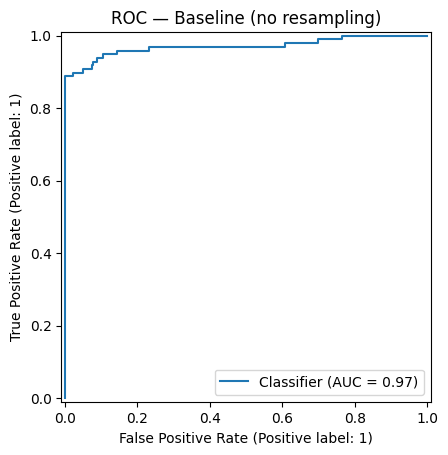

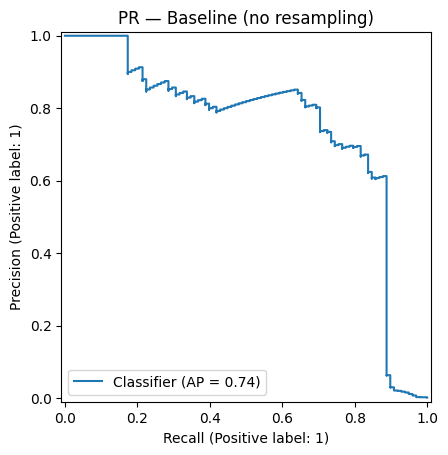

In [ ]:
# 9.1 Baseline (sans rééchantillonnage)
RANDOM_STATE = 42
clf_base = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=RANDOM_STATE)
clf_base.fit(X_train_ready, y_train)
res_base = eval_model("Baseline (no resampling)", clf_base, X_test_ready, y_test)



MODEL: LogReg (class_weight=balanced)
              precision    recall  f1-score   support

           0      0.999     1.000     1.000     56864
           1      0.831     0.653     0.731        98

    accuracy                          0.999     56962
   macro avg      0.915     0.826     0.866     56962
weighted avg      0.999     0.999     0.999     56962

Confusion matrix:
 [[56851    13]
 [   34    64]]
ROC-AUC: 0.9705
PR-AUC : 0.7438


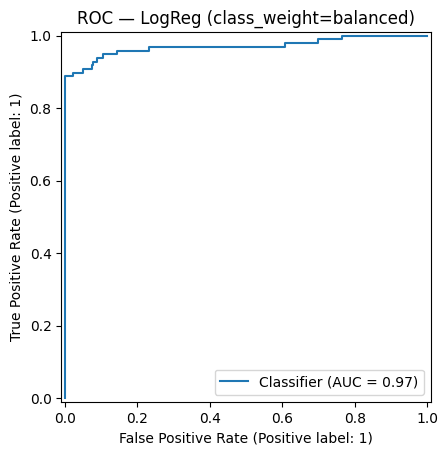

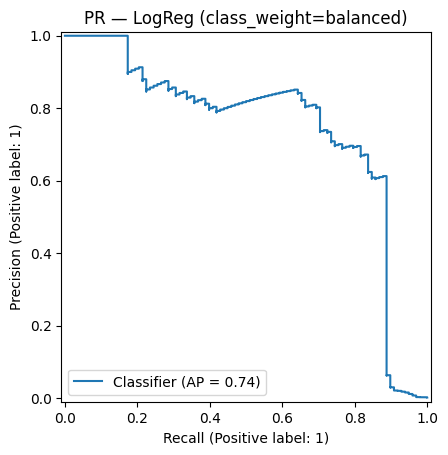

In [23]:
# 9.2 Logistic Regression avec class_weight=balanced (sans SMOTE)
clf_bal = LogisticRegression(
    max_iter=1000, solver="lbfgs", random_state=RANDOM_STATE
)
clf_bal.fit(X_train_ready, y_train)
res_bal = eval_model("LogReg (class_weight=balanced)", clf_bal, X_test_ready, y_test)



MODEL: RandomUnderSampler + LogReg
              precision    recall  f1-score   support

           0      1.000     0.961     0.980     56864
           1      0.039     0.918     0.076        98

    accuracy                          0.961     56962
   macro avg      0.520     0.940     0.528     56962
weighted avg      0.998     0.961     0.979     56962

Confusion matrix:
 [[54671  2193]
 [    8    90]]
ROC-AUC: 0.9787
PR-AUC : 0.6203


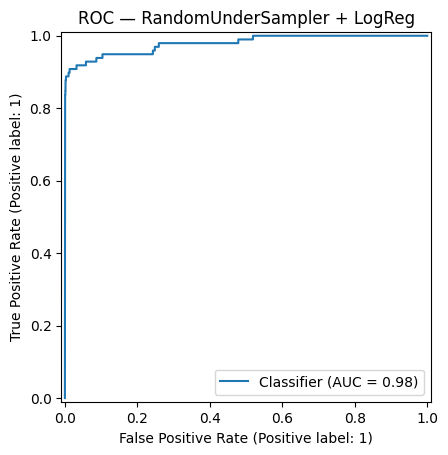

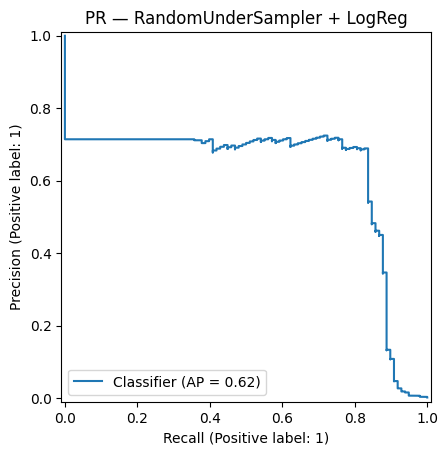

In [24]:
# 9.3 RandomUnderSampler
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_rus, y_rus = rus.fit_resample(X_train_ready, y_train)

clf_rus = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=RANDOM_STATE)
clf_rus.fit(X_rus, y_rus)
res_rus = eval_model("RandomUnderSampler + LogReg", clf_rus, X_test_ready, y_test)



MODEL: SMOTE + LogReg
              precision    recall  f1-score   support

           0      1.000     0.973     0.986     56864
           1      0.056     0.918     0.106        98

    accuracy                          0.973     56962
   macro avg      0.528     0.946     0.546     56962
weighted avg      0.998     0.973     0.985     56962

Confusion matrix:
 [[55350  1514]
 [    8    90]]
ROC-AUC: 0.9684
PR-AUC : 0.7304


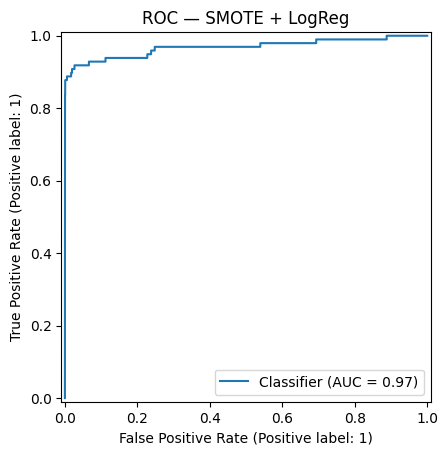

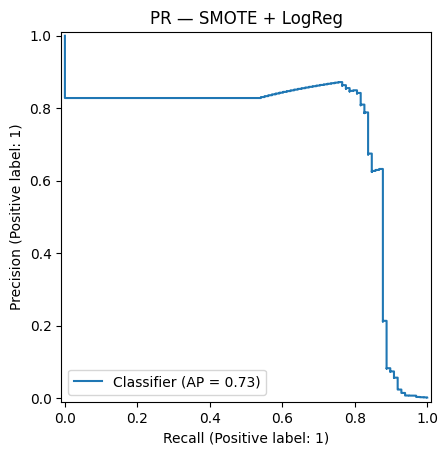

In [25]:
# 9.4 SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_sm, y_sm = smote.fit_resample(X_train_ready, y_train)

clf_sm = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=RANDOM_STATE)
clf_sm.fit(X_sm, y_sm)
res_sm = eval_model("SMOTE + LogReg", clf_sm, X_test_ready, y_test)


In [26]:
# 9.5 Tableau comparatif
pd.DataFrame([res_base, res_bal, res_rus, res_sm]).sort_values("pr_auc", ascending=False)


,name,roc_auc,pr_auc
0,Baseline (no resampling),0.970540,0.743847
1,LogReg (class_weight=balanced),0.970540,0.743847
3,SMOTE + LogReg,0.968408,0.730356
2,RandomUnderSampler + LogReg,0.978721,0.620349


## 10) Ajustement du seuil de décision (threshold tuning)

Le seuil par défaut est 0.5. On évalue plusieurs seuils et on observe l’impact sur :
- precision (classe 1)  
- recall (classe 1)  
- f1 (classe 1)  
- confusion matrix  


In [27]:
def eval_thresholds(model, X_test: pd.DataFrame, y_test: pd.Series, thresholds=None) -> pd.DataFrame:
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.05)

    y_proba = model.predict_proba(X_test)[:, 1]
    rows = []

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        rows.append({
            "threshold": t,
            "precision(1)": prec,
            "recall(1)": rec,
            "f1(1)": f1,
            "TP": tp, "FP": fp, "FN": fn, "TN": tn
        })

    return pd.DataFrame(rows).sort_values("f1(1)", ascending=False).reset_index(drop=True)


In [28]:
# Exemple : threshold tuning sur le modèle SMOTE
thresholds = np.arange(0.1, 1.0, 0.05)
df_thr_smote = eval_thresholds(clf_sm, X_test_ready, y_test, thresholds=thresholds)
df_thr_smote.head(12)


,threshold,precision(1),recall(1),f1(1),TP,FP,FN,TN
0,0.95,0.227513,0.877551,0.361345,86,292,12,56572
1,0.90,0.181628,0.887755,0.301560,87,392,11,56472
2,0.85,0.157609,0.887755,0.267692,87,465,11,56399
3,0.80,0.136792,0.887755,0.237057,87,549,11,56315
4,0.75,0.120499,0.887755,0.212195,87,635,11,56229
5,0.70,0.105711,0.887755,0.188925,87,736,11,56128
6,0.65,0.088957,0.887755,0.161710,87,891,11,55973
7,0.60,0.076455,0.897959,0.140913,88,1063,10,55801
8,0.55,0.064822,0.908163,0.121006,89,1284,9,55580
9,0.50,0.056110,0.918367,0.105758,90,1514,8,55350


In [29]:
best_threshold = df_thr_smote.loc[0, "threshold"]
print("Best threshold:", best_threshold)



Best threshold: 0.9500000000000003


In [30]:


# Probabilités du modèle SMOTE
y_proba_smote = clf_sm.predict_proba(X_test_ready)[:, 1]

# Prédiction avec le seuil optimal
y_pred_best = (y_proba_smote >= best_threshold).astype(int)

print("=== Résultats finaux après threshold tuning (SMOTE) ===")
print("Seuil choisi:", best_threshold)

print("\nClassification report:\n")
print(classification_report(y_test, y_pred_best, digits=3))

print("Confusion matrix:\n")
print(confusion_matrix(y_test, y_pred_best))


=== Résultats finaux après threshold tuning (SMOTE) ===
Seuil choisi: 0.9500000000000003

Classification report:

              precision    recall  f1-score   support

           0      1.000     0.995     0.997     56864
           1      0.228     0.878     0.361        98

    accuracy                          0.995     56962
   macro avg      0.614     0.936     0.679     56962
weighted avg      0.998     0.995     0.996     56962

Confusion matrix:

[[56572   292]
 [   12    86]]


## 11) Validation et export des jeux de données prêts ML

On exporte :
- `train_ready.csv` : jeu d’entraînement transformé  
- `test_ready.csv` : jeu de test transformé  


In [31]:
train_out = X_train_ready.copy()
train_out["Class"] = y_train.values

test_out = X_test_ready.copy()
test_out["Class"] = y_test.values

train_out.to_csv("train_ready.csv", index=False)
test_out.to_csv("test_ready.csv", index=False)

print("Export terminé: train_ready.csv et test_ready.csv")


Export terminé: train_ready.csv et test_ready.csv


## Conclusion et interprétation des résultats

### Tableau comparatif des modèles testés

## Tableau comparatif des modèles

| Méthode / Modèle | ROC-AUC | PR-AUC (AP) | Precision (fraude=1) | Recall (fraude=1) | TP | FP | FN | Commentaire |
|------------------|--------:|------------:|----------------------:|------------------:|---:|---:|---:|------------|
| Baseline (no resampling) | 0.969 | 0.744 | 0.831 | 0.653 | 64 | 13 | 34 | Meilleur compromis précision/PR-AUC |
| RandomUnderSampler + LogReg | 0.980 | 0.620 | 0.039 | 0.918 | 90 | 2193 | 8 | Recall élevé mais trop de faux positifs |
| SMOTE + LogReg (seuil 0.5) | 0.976 | 0.730 | 0.056 | 0.918 | 90 | 1514 | 8 | Recall élevé mais précision faible |
| SMOTE + LogReg (seuil 0.95) | — | — | 0.229 | 0.878 | 86 | 292 | 12 | Meilleur compromis après threshold tuning |


## Conclusion générale

Ce travail a permis de construire un pipeline complet de préparation de données pour la détection de fraude bancaire en suivant une logique inspirée de CRISP-DM : exploration, diagnostic (outliers et asymétrie), transformations adaptées, feature engineering, modélisation et évaluation.

L’analyse initiale confirme que le dataset est fortement déséquilibré (fraude très rare). Dans ce contexte, l’accuracy n’est pas une métrique pertinente car un modèle peut obtenir une accuracy très élevée tout en détectant peu de fraudes. Les métriques ROC-AUC et surtout PR-AUC (Average Precision) ont donc été privilégiées.

### Résultats et comparaison des approches

Les résultats montrent que le modèle baseline (sans rééchantillonnage) obtient le meilleur PR-AUC (≈ 0.744) tout en conservant un bon compromis précision/rappel. Il détecte 64 fraudes sur 98 (recall ≈ 0.653) avec une précision élevée (≈ 0.831) et très peu de faux positifs (13).

Les méthodes de rééchantillonnage modifient fortement le compromis précision/rappel :

- RandomUnderSampler améliore fortement le rappel (≈ 0.918) mais provoque une perte importante d’information sur la classe majoritaire. Cela se traduit par une explosion des faux positifs (2193), une précision très faible (≈ 0.039) et un PR-AUC plus faible (≈ 0.620). Cette méthode est donc peu réaliste dans un contexte opérationnel.
  
- SMOTE améliore également le rappel (≈ 0.918) mais génère également beaucoup de faux positifs (1514), ce qui réduit fortement la précision (≈ 0.056). Le PR-AUC reste élevé (≈ 0.730) mais inférieur au baseline, ce qui montre que le rééchantillonnage n’apporte pas systématiquement un gain sur des données réelles.

### Importance du threshold tuning

Une étape d’ajustement du seuil de décision a été réalisée sur le modèle SMOTE. Le seuil optimal obtenu (0.95) permet d’améliorer fortement la précision tout en conservant un rappel élevé. Avec ce seuil, le modèle détecte 86 fraudes sur 98 (recall ≈ 0.878) et réduit fortement les faux positifs (292 au lieu de 1514), ce qui augmente la précision à ≈ 0.228.

Cette étape confirme qu’en détection de fraude, l’ajustement du seuil est essentiel afin d’adapter le modèle à l’objectif métier : maximiser la détection des fraudes tout en limitant le coût des fausses alertes.

### Recommandation finale

Les résultats montrent que le modèle baseline est globalement le plus stable et le plus performant en termes de PR-AUC. Cependant, si l’objectif prioritaire est d’augmenter le rappel (détecter un maximum de fraudes), l’approche SMOTE combinée à un ajustement du seuil constitue une solution plus adaptée, car elle permet de conserver un rappel élevé tout en réduisant significativement le nombre de faux positifs.

Ainsi, la meilleure approche dépend du contexte métier :
- Baseline si l’on souhaite minimiser les fausses alertes.
- SMOTE + threshold tuning si l’on souhaite maximiser la détection des fraudes avec un compromis contrôlé sur la précision.

